# REDO of SMA Graphs

Due to the way that Medications were categorized, disparities amongst insurances were hard to determine, so I redid it.

In [1]:
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import chi2_contingency

def read_excel_files(folder_path):
    excel_dict = {}
    
    # Get a list of all files in the specified folder
    files = os.listdir(folder_path)
    
    # Iterate over each file in the folder
    for file in files:
        # Check if the file has an Excel extension (.xlsx or .xls)
        if file.endswith('.xlsx') or file.endswith('.xls'):
            file_path = os.path.join(folder_path, file)
            
            # Read the Excel file into a DataFrame
            df = pd.read_excel(file_path)
            
            # Add the DataFrame to the dictionary with the file name as the key
            excel_dict[file] = df
    
    return excel_dict

excel_dict = read_excel_files('./sma_data')

print("Sheets in the Excel dict:")
for sheet_name in excel_dict.keys():
    print(sheet_name)
def remove_high_missing_columns(df, threshold=0.99):
    missing_percentages = df.isnull().mean()
    
    # Identify columns with missing values above the threshold
    columns_to_remove = missing_percentages[missing_percentages > threshold].index
    
    # Remove the identified columns from the DataFrame
    df = df.drop(columns=columns_to_remove)
    return df


demographics_df = remove_high_missing_columns(excel_dict['DEMO.xlsx'])
demographics_df = demographics_df.drop(columns=['hltinosp', 'nonmdapc', 'inschool', 'inschyes', 'edulvl', 'edulvl1', 'edulvl2', 'employ', 'has_mname', 'dob1'])
enco_df = remove_high_missing_columns(excel_dict['ENCO.xlsx'])
hospitalizations_df = remove_high_missing_columns(excel_dict['Hospitalization Repeat Group.xlsx'])
medications_df = remove_high_missing_columns(excel_dict['Medication Repeat Group.xlsx'])
diagnosis_df = remove_high_missing_columns(excel_dict['DIAG.xlsx'])
discontinuation_df = remove_high_missing_columns(excel_dict['DISC.xlsx'])
pulmonary_df = remove_high_missing_columns(excel_dict['Pulmonary Device Repeat Group.xlsx'])
dob_df = pd.read_excel('./sma_data/SMA-DOB_May2024.xlsx')
demographics_df = demographics_df.merge(dob_df, on='FACPATID', how='left')

/Users/danieljoo/miniconda3/envs/dj/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Sheets in the Excel dict:
Spinraza Maintenance Dose Repeat Group.xlsx
SMA-DOB_May2024.xlsx
NPI Repeat Group.xlsx
Pulmonary Device Repeat Group.xlsx
Trial Details.xlsx
Surgery Repeat Group.xlsx
sma_clean.xlsx
Fundoplication Nissen Repeat Group.xlsx
Assisstive Device Repeat Group.xlsx
Hospitalization Repeat Group.xlsx
DISC.xlsx
LOG.xlsx
DIAG.xlsx
ENCO.xlsx
Medication Repeat Group.xlsx
DEMO.xlsx


In [2]:
medications_df

,FACPATID,CASE_ID,SCHEDULED_FORM_NAME,medname,medname1,medoth,medstdt,medstdt.P,medstpdt,medstpdt.P,medong,dstype,medong1
0,1021-8,1,SMA Encounter,Budesonide,NaN,NaN,03/25/2013 12:00:00 AM,day,NaN,NaN,1.0,NaN,NaN
1,1021-8,1,SMA Encounter,Zyprexa,NaN,levalbuterol,06/20/2013 12:00:00 AM,day,NaN,NaN,1.0,NaN,NaN
2,1021-8,2,SMA Encounter,Budesonide,NaN,NaN,03/25/2013 12:00:00 AM,day,NaN,NaN,1.0,NaN,NaN
3,1021-8,2,SMA Encounter,Zyprexa,NaN,levalbuterol,06/20/2013 12:00:00 AM,day,NaN,NaN,1.0,NaN,NaN
4,1021-8,3,SMA Encounter,Budesonide,NaN,NaN,03/25/2013 12:00:00 AM,day,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7188,9001-49,44,Log,NaN,cetirizine,NaN,11/01/2021 12:00:00 AM,day,NaN,NaN,NaN,SMA,Yes
7189,9001-49,44,Log,NaN,Atarax,NaN,01/19/2021 12:00:00 AM,day,NaN,NaN,NaN,SMA,Yes
7190,9001-50,45,Log,NaN,Atarax,NaN,04/29/2021 12:00:00 AM,day,NaN,NaN,NaN,SMA,Yes
7191,9001-50,45,Log,NaN,cetirizine,NaN,11/01/2021 12:00:00 AM,day,NaN,NaN,NaN,SMA,Yes


In [3]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(medications_df):
    medications_df = medications_df.drop(columns=['CASE_ID', 'SCHEDULED_FORM_NAME', 'medstdt', 'medstdt.P', 'medstpdt', 'medstpdt.P', 'medong', 'dstype', 'medong1'])
    def get_med(row):
        if str(row['medname']).lower() in ['risdiplam', 'spinraza', 'zolgensma', 'nusinersen', 'evrysdi']:
            med = str(row['medname'])
        elif str(row['medname1']).lower() in ['risdiplam', 'spinraza', 'zolgensma', 'nusinersen', 'evrysdi']:
            med = str(row['medname1'])
        elif str(row['medoth']).lower() in ['risdiplam', 'spinraza', 'zolgensma', 'nusinersen', 'evrysdi']:
            med = str(row['medoth'])
        else:
            return 'None'
        if med.lower() in ['evrysdi', 'risdiplam']:
            return 'Risdiplam'
        elif med.lower() in ['nusinersen', 'spinraza']:
            return 'Spinraza'
        elif med.lower() in ['zolgensma']:
            return 'Zolgensma'
        return 'None'
    medications_df['meds'] = medications_df.apply(get_med, axis=1)
    medications_df = medications_df[medications_df['meds'].notna()]
    medications_df = medications_df.drop(columns=['medname', 'medname1', 'medoth'])
    medications_df.drop_duplicates(inplace=True)
    return medications_df

medications_df_clean = clean_data(medications_df.copy())
medications_df_clean.head()

,FACPATID,meds
0,1021-8,None
13,1021-25,None
21,1021-26,None
31,1021-30,None
35,1021-38,None


In [4]:
yes_med_df = medications_df_clean[medications_df_clean['meds'] != 'None']

In [5]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(medications_df_clean):
    def no_med(series):
        # If any medication other than 'None' is found, return it
        for med in series:
            if med != 'None':
                return med
        # If only 'None' is present, return 'None'
        return 'None'
    # Use groupby and apply instead of aggregate
    medications_df_clean['no_med'] = medications_df_clean.groupby('FACPATID').transform(no_med)
    # Sort by column: 'FACPATID' (ascending)
    medications_df_clean = medications_df_clean.sort_values(['FACPATID'])
    medications_df_clean = medications_df_clean[medications_df_clean['no_med'] == 'None']
    medications_df_clean = medications_df_clean.drop(columns=['no_med'])
    return medications_df_clean

no_med_df = clean_data(medications_df_clean.copy())
no_med_df.head()

medications_df_clean = pd.concat([yes_med_df, no_med_df], axis=0)
medications_df_clean


,FACPATID,meds
111,1063-6,Risdiplam
123,1063-7,Risdiplam
132,1064-2,Spinraza
133,1064-9,Spinraza
143,1064-22,Spinraza
...,...,...
7185,1449-55,None
7186,1449-56,None
5576,9000-2,None
7188,9001-49,None


In [6]:
medications_df_clean = pd.merge(medications_df_clean, dob_df, on='FACPATID', how='inner')
medications_df_clean = pd.merge(medications_df_clean, demographics_df[['FACPATID', 'gender', 'ethnic', 'hltin']], on='FACPATID', how='inner')
medications_df_clean = pd.merge(medications_df_clean, diagnosis_df[['FACPATID', 'smadgndt', 'smaclass']], on='FACPATID', how='inner')

In [7]:
df = medications_df_clean.copy()
df = pd.merge(df, diagnosis_df[['FACPATID', 'smadgmad']], on='FACPATID', how='inner')
df = df[df['smadgmad'] != 'Prenatal Screening']

In [8]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    df['age_dx'] = ((pd.to_datetime(df['smadgndt']) - df['dob']).dt.days) / 365
    def simplify_class(sma_type):
        if 'Type 1' in sma_type:
            return '1'
        elif 'Type 2' in sma_type:
            return '2'
        elif 'Type 3' in sma_type:
            return '3'
        elif 'Type 4' in sma_type:
            return '4'
        elif 'Other' in sma_type or 'Unknown' in sma_type:
            return None
        else:
            return 'Pre-symptomatic'
    df['smaclass'] = df['smaclass'].apply(simplify_class)
    df.drop(columns=['smadgndt', 'dob'], inplace=True)
    df = df[df['smaclass'].notna()]
    return df

df_clean = clean_data(df.copy())
df_clean.head()

/var/folders/_0/c6fzcd295qz6fty96376ybv00000gn/T/ipykernel_40170/2856106912.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['age_dx'] = ((pd.to_datetime(df['smadgndt']) - df['dob']).dt.days) / 365


,FACPATID,meds,gender,ethnic,hltin,smaclass,smadgmad,age_dx
0,1064-2,Spinraza,Male,White,"Medicaid,Medicare",2,Clinical presentation of symptoms,0.641096
1,1064-22,Spinraza,Male,White,Medicaid,3,Clinical presentation of symptoms,1.926027
2,1064-28,Spinraza,Male,White,Private or group health insurance,3,Clinical presentation of symptoms,9.789041
3,1095-2,Spinraza,Male,White,Medicaid,2,Clinical presentation of symptoms,4.295890
5,1095-21,Spinraza,Female,White,"Other, specify:",2,Clinical presentation of symptoms,0.884932


In [9]:
def simplify_hltin(row):
    insurance = row['hltin']
    age = row['age_dx']
    # Handle NaN values
    if pd.isna(insurance):
        return insurance
    insurance = str(insurance).lower()
    # Special case for pediatric patients with Medicare+Medicaid
    if age < 65 and insurance == 'medicaid,medicare':
        return 'medicaid'
    # Original logic
    if insurance == 'private or group health insurance':
        return 'private or group health insurance'
    elif insurance == 'medicaid':
        return 'medicaid'
    elif ('private or group health insurance' in insurance) and ('medicaid' in insurance):
        return 'both'
    else:
        return 'other'

df_clean['hltin'] = df_clean.apply(simplify_hltin, axis=1)

In [10]:
df_clean.rename(columns={'smaclass': 'sma_type'}, inplace=True)
df_clean.head()
df_clean = df_clean[df_clean['sma_type'] != '4']
def simplify_race(ethnic):
    if ethnic in ['White', 'Black or African American']:
        return ethnic
    else:
        return 'Other'

df_clean['ethnic'] = df_clean['ethnic'].apply(simplify_race)

In [11]:
import pandas as pd
import numpy as np

def calculate_percentage(count, total):
    """Calculate percentage safely avoiding division by zero"""
    if total == 0:
        return "0 (0.0%)"  # Added % symbol
    return f"{count} ({(count/total*100):.1f}%)"  # Added % symbol

def create_clinical_table(sma_df_clean, include_percentages=True):
    """
    Create a comprehensive clinical characteristics table for SMA patients by treatment type
    """
    # Define medication groups in specified order
    treatments = ['None', 'Risdiplam', 'Spinraza', 'Zolgensma']
    
    # Initialize dictionary to store results
    results = {}
    
    for treatment in treatments:
        # Special handling for 'None' category
        # if treatment == 'None':
        #     group = sma_df_clean[sma_df_clean['meds'].isna()]
        # else:
        group = sma_df_clean[sma_df_clean['meds'] == treatment]
            
        n = len(group)
        
        # Create column header with n
        col_name = f"{treatment} (n={n})"
        results[col_name] = {}
        
        # Age at diagnosis
        if n > 0:
            mean_age = group['age_dx'].mean()
            std_age = group['age_dx'].std()
            results[col_name]['Age at diagnosis, mean (sd)'] = f"{mean_age:.2f} ({std_age:.2f})"
        else:
            results[col_name]['Age at diagnosis, mean (sd)'] = "NA"
        
        # For counts-only version
        if not include_percentages:
            # SMA Class
            results[col_name]['SMA Class'] = ""
            results[col_name]['Pre-symptomatic'] = str((group['sma_type'] == 'Pre-symptomatic').sum())
            results[col_name]['1'] = str((group['sma_type'] == '1').sum())
            results[col_name]['2'] = str((group['sma_type'] == '2').sum())
            results[col_name]['3'] = str((group['sma_type'] == '3').sum())
            
            # Race
            results[col_name]['Race'] = ""
            results[col_name]['Black or African American'] = str((group['ethnic'] == 'Black or African American').sum())
            results[col_name]['White'] = str((group['ethnic'] == 'White').sum())
            results[col_name]['Other'] = str((~group['ethnic'].isin(['Black or African American', 'White']) & group['ethnic'].notna()).sum())
            
            # Sex
            results[col_name]['Sex'] = ""
            results[col_name]['Male'] = str((group['gender'] == 'Male').sum())
            results[col_name]['Female'] = str((group['gender'] == 'Female').sum())
            
            # Insurance Status
            results[col_name]['Insurance Status'] = ""
            results[col_name]['Medicaid'] = str((group['hltin'] == 'medicaid').sum())
            results[col_name]['Private/Group'] = str((group['hltin'] == 'private or group health insurance').sum())
            results[col_name]['Both'] = str((group['hltin'] == 'both').sum())
            results[col_name]['Other Insurance'] = str((~group['hltin'].isin(['medicaid', 'private or group health insurance', 'both']) & group['hltin'].notna()).sum())
        
        else:
            # SMA Class
            results[col_name]['SMA Class'] = ""
            count_presymp = (group['sma_type'] == 'Pre-symptomatic').sum()
            count_1 = (group['sma_type'] == '1').sum()
            count_2 = (group['sma_type'] == '2').sum()
            count_3 = (group['sma_type'] == '3').sum()
            
            results[col_name]['Pre-symptomatic'] = calculate_percentage(count_presymp, n)
            results[col_name]['1'] = calculate_percentage(count_1, n)
            results[col_name]['2'] = calculate_percentage(count_2, n)
            results[col_name]['3'] = calculate_percentage(count_3, n)
            
            # Race
            results[col_name]['Race'] = ""
            count_aa = (group['ethnic'] == 'Black or African American').sum()
            count_white = (group['ethnic'] == 'White').sum()
            count_other = (~group['ethnic'].isin(['Black or African American', 'White']) & group['ethnic'].notna()).sum()
            
            results[col_name]['African American'] = calculate_percentage(count_aa, n)
            results[col_name]['White'] = calculate_percentage(count_white, n)
            results[col_name]['Other'] = calculate_percentage(count_other, n)
            
            # Sex
            results[col_name]['Sex'] = ""
            count_male = (group['gender'] == 'Male').sum()
            count_female = (group['gender'] == 'Female').sum()
            
            results[col_name]['Male'] = calculate_percentage(count_male, n)
            results[col_name]['Female'] = calculate_percentage(count_female, n)
            
            # Insurance Status
            results[col_name]['Insurance Status'] = ""
            count_medicaid = (group['hltin'] == 'medicaid').sum()
            count_private = (group['hltin'] == 'private or group health insurance').sum()
            count_both = (group['hltin'] == 'both').sum()
            count_other_ins = (~group['hltin'].isin(['medicaid', 'private or group health insurance', 'both']) & group['hltin'].notna()).sum()
            
            results[col_name]['Medicaid Only'] = calculate_percentage(count_medicaid, n)
            results[col_name]['Private/Group'] = calculate_percentage(count_private, n)
            results[col_name]['Both'] = calculate_percentage(count_private, n)
            results[col_name]['Other Insurance'] = calculate_percentage(count_other_ins, n)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# Rest of the code remains the same...

def style_clinical_table(df):
    """
    Apply styling to the clinical characteristics table
    """
    # Define header rows (rows that shouldn't have numbers)
    header_rows = ['SMA Class', 'Race', 'Sex', 'Insurance Status']
    
    def style_row(row):
        if row.name in header_rows:
            return ['font-weight: bold'] * len(row)
        return [''] * len(row)
    
    return df.style\
        .apply(style_row, axis=1)\
        .set_properties(**{
            'text-align': 'center',
            'padding': '5px'
        })\
        .set_table_styles([
            {'selector': 'th',
             'props': [('text-align', 'left'),
                      ('font-weight', 'bold'),
                      ('padding', '5px')]},
        ])

# Usage example for table with percentages:
# summary_table_with_pct = create_clinical_table(sma_df_clean, include_percentages=True)
# styled_table_with_pct = style_clinical_table(summary_table_with_pct)
# display(styled_table_with_pct)

# Usage example for table without percentages:
# summary_table_no_pct = create_clinical_table(sma_df_clean, include_percentages=False)
# styled_table_no_pct = style_clinical_table(summary_table_no_pct)
# display(styled_table_no_pct)

In [12]:
import pandas as pd
import numpy as np

def calculate_percentage(count, total):
    """Calculate percentage safely avoiding division by zero"""
    if total == 0:
        return "0 (0.0%)"
    return f"{count} ({(count/total*100):.1f}%)"

def create_clinical_table(sma_df_clean, include_percentages=True):
    """
    Create a comprehensive clinical characteristics table for SMA patients by treatment type,
    accounting for patients with multiple treatments
    """
    # Define medication groups in specified order
    treatments = ['None', 'Risdiplam', 'Spinraza', 'Zolgensma']
    
    # Initialize dictionary to store results
    results = {}
    
    # Calculate total unique patients for the "Total" column
    total_patients = len(sma_df_clean['FACPATID'].unique())
    results[f"Total (n={total_patients})"] = {}
    
    # Get unique patient data for total calculations (taking first occurrence of each patient)
    unique_patient_df = sma_df_clean.drop_duplicates(subset=['FACPATID'], keep='first')
    
    # Calculate statistics for the total column using unique patients
    if total_patients > 0:
        mean_age_total = unique_patient_df['age_dx'].mean()
        std_age_total = unique_patient_df['age_dx'].std()
        results[f"Total (n={total_patients})"]["Age at diagnosis, mean (sd)"] = f"{mean_age_total:.2f} ({std_age_total:.2f})"
    else:
        results[f"Total (n={total_patients})"]["Age at diagnosis, mean (sd)"] = "NA"
    
    # Calculate individual treatment groups
    for treatment in treatments:
        group = sma_df_clean[sma_df_clean['meds'] == treatment]
        n = len(group)
        col_name = f"{treatment} (n={n})"
        results[col_name] = {}
        
        # Age at diagnosis
        if n > 0:
            mean_age = group['age_dx'].mean()
            std_age = group['age_dx'].std()
            results[col_name]['Age at diagnosis, mean (sd)'] = f"{mean_age:.2f} ({std_age:.2f})"
        else:
            results[col_name]['Age at diagnosis, mean (sd)'] = "NA"
        
        # For counts and percentages
        if include_percentages:
            # SMA Class
            results[col_name]['SMA Class'] = ""
            results[f"Total (n={total_patients})"]["SMA Class"] = ""
            
            for sma_type in ['Pre-symptomatic', '1', '2', '3']:
                count = (group['sma_type'] == sma_type).sum()
                total_count = (unique_patient_df['sma_type'] == sma_type).sum()
                
                results[col_name][sma_type] = calculate_percentage(count, n)
                results[f"Total (n={total_patients})"][sma_type] = calculate_percentage(total_count, total_patients)
            
            # Race
            results[col_name]['Race'] = ""
            results[f"Total (n={total_patients})"]["Race"] = ""
            
            for race, race_display in [
                ('Black or African American', 'African American'),
                ('White', 'White'),
                (None, 'Other')  # None will be handled specially for "Other" category
            ]:
                if race is None:
                    count = (~group['ethnic'].isin(['Black or African American', 'White']) & group['ethnic'].notna()).sum()
                    total_count = (~unique_patient_df['ethnic'].isin(['Black or African American', 'White']) & unique_patient_df['ethnic'].notna()).sum()
                else:
                    count = (group['ethnic'] == race).sum()
                    total_count = (unique_patient_df['ethnic'] == race).sum()
                
                results[col_name][race_display] = calculate_percentage(count, n)
                results[f"Total (n={total_patients})"][race_display] = calculate_percentage(total_count, total_patients)
            
            # Sex
            results[col_name]['Sex'] = ""
            results[f"Total (n={total_patients})"]["Sex"] = ""
            
            for gender in ['Male', 'Female']:
                count = (group['gender'] == gender).sum()
                total_count = (unique_patient_df['gender'] == gender).sum()
                
                results[col_name][gender] = calculate_percentage(count, n)
                results[f"Total (n={total_patients})"][gender] = calculate_percentage(total_count, total_patients)
            
            # Insurance Status
            results[col_name]['Insurance Status'] = ""
            results[f"Total (n={total_patients})"]["Insurance Status"] = ""
            
            insurance_mapping = {
                'medicaid': 'Medicaid',
                'private or group health insurance': 'Private/Group',
                'both': 'Both',
                None: 'Other Insurance'
            }
            
            for ins_type, display_name in insurance_mapping.items():
                if ins_type is None:
                    count = (~group['hltin'].isin(['medicaid', 'private or group health insurance', 'both']) & group['hltin'].notna()).sum()
                    total_count = (~unique_patient_df['hltin'].isin(['medicaid', 'private or group health insurance', 'both']) & unique_patient_df['hltin'].notna()).sum()
                else:
                    count = (group['hltin'] == ins_type).sum()
                    total_count = (unique_patient_df['hltin'] == ins_type).sum()
                
                results[col_name][display_name] = calculate_percentage(count, n)
                results[f"Total (n={total_patients})"][display_name] = calculate_percentage(total_count, total_patients)
        
        else:
            # For counts only version
            for category in ['SMA Class', 'Race', 'Sex', 'Insurance Status']:
                results[col_name][category] = ""
                results[f"Total (n={total_patients})"][category] = ""
            
            # SMA Class counts
            for sma_type in ['Pre-symptomatic', '1', '2', '3']:
                count = (group['sma_type'] == sma_type).sum()
                total_count = (unique_patient_df['sma_type'] == sma_type).sum()
                results[col_name][sma_type] = str(count)
                results[f"Total (n={total_patients})"][sma_type] = str(total_count)
            
            # Race counts
            for race in ['Black or African American', 'White']:
                count = (group['ethnic'] == race).sum()
                total_count = (unique_patient_df['ethnic'] == race).sum()
                results[col_name][race] = str(count)
                results[f"Total (n={total_patients})"][race] = str(total_count)
            
            other_count = (~group['ethnic'].isin(['Black or African American', 'White']) & group['ethnic'].notna()).sum()
            total_other_count = (~unique_patient_df['ethnic'].isin(['Black or African American', 'White']) & unique_patient_df['ethnic'].notna()).sum()
            results[col_name]['Other'] = str(other_count)
            results[f"Total (n={total_patients})"]["Other"] = str(total_other_count)
            
            # Sex counts
            for gender in ['Male', 'Female']:
                count = (group['gender'] == gender).sum()
                total_count = (unique_patient_df['gender'] == gender).sum()
                results[col_name][gender] = str(count)
                results[f"Total (n={total_patients})"][gender] = str(total_count)
            
            # Insurance counts
            medicaid_count = (group['hltin'] == 'medicaid').sum()
            private_count = (group['hltin'] == 'private or group health insurance').sum()
            both_count = (group['hltin'] == 'both').sum()
            other_ins_count = (~group['hltin'].isin(['medicaid', 'private or group health insurance', 'both']) & group['hltin'].notna()).sum()
            
            total_medicaid = (unique_patient_df['hltin'] == 'medicaid').sum()
            total_private = (unique_patient_df['hltin'] == 'private or group health insurance').sum()
            total_both = (unique_patient_df['hltin'] == 'both').sum()
            total_other_ins = (~unique_patient_df['hltin'].isin(['medicaid', 'private or group health insurance', 'both']) & unique_patient_df['hltin'].notna()).sum()
            
            results[col_name]['Medicaid Only'] = str(medicaid_count)
            results[col_name]['Private/Group'] = str(private_count)
            results[col_name]['Both'] = str(both_count)
            results[col_name]['Other Insurance'] = str(other_ins_count)
            
            results[f"Total (n={total_patients})"]["Medicaid Only"] = str(total_medicaid)
            results[f"Total (n={total_patients})"]["Private/Group"] = str(total_private)
            results[f"Total (n={total_patients})"]["Both"] = str(total_both)
            results[f"Total (n={total_patients})"]["Other Insurance"] = str(total_other_ins)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Reorder columns to put Total at the end
    cols = results_df.columns.tolist()
    cols.remove(f"Total (n={total_patients})")
    cols.append(f"Total (n={total_patients})")
    results_df = results_df[cols]
    
    return results_df

def style_clinical_table(df):
    """
    Apply styling to the clinical characteristics table
    """
    # Define header rows (rows that shouldn't have numbers)
    header_rows = ['SMA Class', 'Race', 'Sex', 'Insurance Status']
    
    def style_row(row):
        if row.name in header_rows:
            return ['font-weight: bold'] * len(row)
        return [''] * len(row)
    
    return df.style\
        .apply(style_row, axis=1)\
        .set_properties(**{
            'text-align': 'center',
            'padding': '5px'
        })\
        .set_table_styles([
            {'selector': 'th',
             'props': [('text-align', 'left'),
                      ('font-weight', 'bold'),
                      ('padding', '5px')]},
        ])

# Usage example:
# summary_table = create_clinical_table(sma_df_clean, include_percentages=True)
# styled_table = style_clinical_table(summary_table)
# display(styled_table)

In [13]:
df_clean

,FACPATID,meds,gender,ethnic,hltin,sma_type,smadgmad,age_dx
0,1064-2,Spinraza,Male,White,medicaid,2,Clinical presentation of symptoms,0.641096
1,1064-22,Spinraza,Male,White,medicaid,3,Clinical presentation of symptoms,1.926027
2,1064-28,Spinraza,Male,White,private or group health insurance,3,Clinical presentation of symptoms,9.789041
3,1095-2,Spinraza,Male,White,medicaid,2,Clinical presentation of symptoms,4.295890
5,1095-21,Spinraza,Female,White,other,2,Clinical presentation of symptoms,0.884932
...,...,...,...,...,...,...,...,...
360,1433-52,None,Female,White,other,3,Clinical presentation of symptoms,1.504110
361,1449-50,None,Male,Other,private or group health insurance,1,Newborn Screening,0.021918
363,1449-56,None,Female,White,private or group health insurance,1,Newborn Screening,0.032877
365,9001-49,None,Male,Black or African American,medicaid,Pre-symptomatic,Unknown,0.854795


In [14]:
sma_df_clean = df_clean.copy()

# Create and display table with percentages
summary_table_with_pct = create_clinical_table(sma_df_clean, include_percentages=True)
styled_table_with_pct = style_clinical_table(summary_table_with_pct)
display(styled_table_with_pct)

# Create and display table without percentages
summary_table_no_pct = create_clinical_table(sma_df_clean, include_percentages=False)
styled_table_no_pct = style_clinical_table(summary_table_no_pct)
display(styled_table_no_pct)

,None (n=59),Risdiplam (n=85),Spinraza (n=149),Zolgensma (n=36),Total (n=285)
"Age at diagnosis, mean (sd)",3.15 (7.34),2.18 (4.21),2.82 (6.35),0.23 (0.44),2.71 (6.11)
SMA Class,,,,,
Pre-symptomatic,9 (15.3%),6 (7.1%),9 (6.0%),15 (41.7%),31 (10.9%)
1,18 (30.5%),40 (47.1%),53 (35.6%),18 (50.0%),105 (36.8%)
2,18 (30.5%),25 (29.4%),50 (33.6%),3 (8.3%),88 (30.9%)
3,14 (23.7%),14 (16.5%),37 (24.8%),0 (0.0%),61 (21.4%)
Race,,,,,
African American,7 (11.9%),8 (9.4%),15 (10.1%),5 (13.9%),31 (10.9%)
White,36 (61.0%),56 (65.9%),110 (73.8%),25 (69.4%),197 (69.1%)
Other,16 (27.1%),21 (24.7%),24 (16.1%),6 (16.7%),57 (20.0%)


,None (n=59),Risdiplam (n=85),Spinraza (n=149),Zolgensma (n=36),Total (n=285)
"Age at diagnosis, mean (sd)",3.15 (7.34),2.18 (4.21),2.82 (6.35),0.23 (0.44),2.71 (6.11)
SMA Class,,,,,
Race,,,,,
Sex,,,,,
Insurance Status,,,,,
Pre-symptomatic,9,6,9,15,31
1,18,40,53,18,105
2,18,25,50,3,88
3,14,14,37,0,61
Black or African American,7,8,15,5,31


In [15]:
styled_table_with_pct.data.to_excel('table.xlsx')


Medication Usage Statistics:
Total patients: 285
Risdiplam only: 56 (19.6%)
Spinraza only: 115 (40.4%)
Zolgensma only: 16 (5.6%)
No medications: 59 (20.7%)


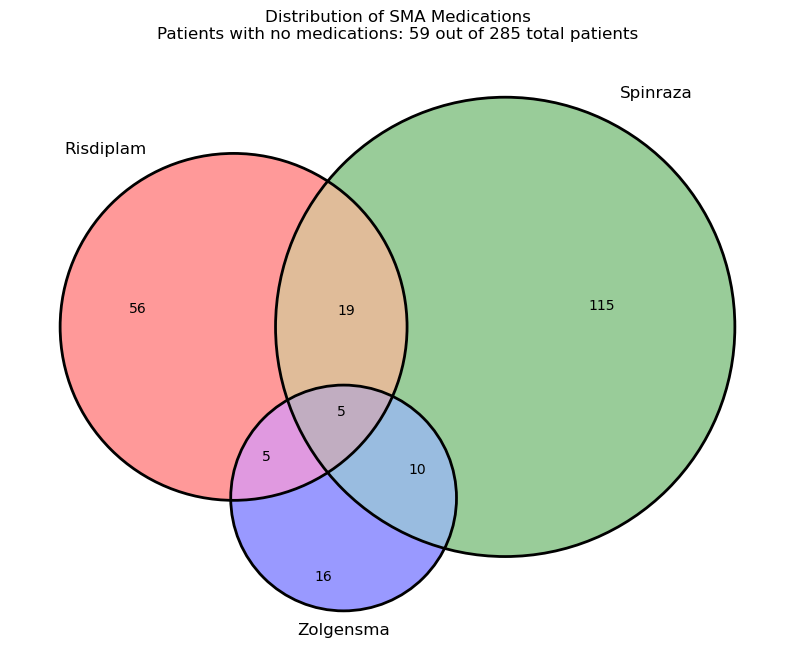

In [16]:
import pandas as pd
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt

def create_medication_venn(sma_df_clean):
    # Create sets for each medication
    risdiplam_patients = set(sma_df_clean[sma_df_clean['meds'].str.contains('Risdiplam', na=False)]['FACPATID'])
    spinraza_patients = set(sma_df_clean[sma_df_clean['meds'].str.contains('Spinraza', na=False)]['FACPATID'])
    zolgensma_patients = set(sma_df_clean[sma_df_clean['meds'].str.contains('Zolgensma', na=False)]['FACPATID'])
    
    # Get patients with no medications
    no_meds_patients = set(sma_df_clean[sma_df_clean['meds'].str.contains('None', na=False)]['FACPATID'])
    
    # Calculate total number of patients
    total_patients = len(set(sma_df_clean['FACPATID']))
    
    # Create the Venn diagram
    plt.figure(figsize=(10, 10))
    venn = venn3([risdiplam_patients, spinraza_patients, zolgensma_patients], 
                 set_labels=('Risdiplam', 'Spinraza', 'Zolgensma'))
    
    # Add circles for better visibility
    venn3_circles([risdiplam_patients, spinraza_patients, zolgensma_patients])
    
    # Add title with information about patients with no medications
    plt.title(f'Distribution of SMA Medications\nPatients with no medications: {len(no_meds_patients)} out of {total_patients} total patients')
    
    # Calculate and print percentages
    print(f"\nMedication Usage Statistics:")
    print(f"Total patients: {total_patients}")
    print(f"Risdiplam only: {len(risdiplam_patients - spinraza_patients - zolgensma_patients)} ({(len(risdiplam_patients - spinraza_patients - zolgensma_patients)/total_patients)*100:.1f}%)")
    print(f"Spinraza only: {len(spinraza_patients - risdiplam_patients - zolgensma_patients)} ({(len(spinraza_patients - risdiplam_patients - zolgensma_patients)/total_patients)*100:.1f}%)")
    print(f"Zolgensma only: {len(zolgensma_patients - risdiplam_patients - spinraza_patients)} ({(len(zolgensma_patients - risdiplam_patients - spinraza_patients)/total_patients)*100:.1f}%)")
    print(f"No medications: {len(no_meds_patients)} ({(len(no_meds_patients)/total_patients)*100:.1f}%)")
    
    return plt

# Example usage:
venn_plot = create_medication_venn(sma_df_clean)
venn_plot.show()

# Analysis of Medication Usage across insurance status

In [17]:
sma_df_clean = pd.merge(sma_df_clean, diagnosis_df[['FACPATID', 'smadgndt']], on='FACPATID', how='inner')
df = sma_df_clean.copy()
df

,FACPATID,meds,gender,ethnic,hltin,sma_type,smadgmad,age_dx,smadgndt
0,1064-2,Spinraza,Male,White,medicaid,2,Clinical presentation of symptoms,0.641096,11/01/1985 12:00:00 AM
1,1064-22,Spinraza,Male,White,medicaid,3,Clinical presentation of symptoms,1.926027,01/01/2000 12:00:00 AM
2,1064-28,Spinraza,Male,White,private or group health insurance,3,Clinical presentation of symptoms,9.789041,01/01/1996 12:00:00 AM
3,1095-2,Spinraza,Male,White,medicaid,2,Clinical presentation of symptoms,4.295890,01/01/1987 12:00:00 AM
4,1095-21,Spinraza,Female,White,other,2,Clinical presentation of symptoms,0.884932,10/01/1981 12:00:00 AM
...,...,...,...,...,...,...,...,...,...
324,1433-52,None,Female,White,other,3,Clinical presentation of symptoms,1.504110,12/16/2020 12:00:00 AM
325,1449-50,None,Male,Other,private or group health insurance,1,Newborn Screening,0.021918,04/07/2021 12:00:00 AM
326,1449-56,None,Female,White,private or group health insurance,1,Newborn Screening,0.032877,04/26/2021 12:00:00 AM
327,9001-49,None,Male,Black or African American,medicaid,Pre-symptomatic,Unknown,0.854795,04/26/2019 12:00:00 AM


In [18]:
"""
Cell generated by Data Wrangler.
"""
def isolate_med(df, med='Zolgensma'):
    # One-liner using transform to maintain the DataFrame structure
    df['meds'] = df.groupby('FACPATID')['meds'].transform(lambda x: med if med in x.values else 'No ' + med)
    df.drop_duplicates(['FACPATID', 'meds'], inplace=True)
    df.reset_index(inplace=True)
    return df

zolgensma_df = isolate_med(df.copy(), med='Zolgensma')
spinraza_df = isolate_med(df.copy(), med='Spinraza')
risdiplam_df = isolate_med(df.copy(), med='Risdiplam')
zolgensma_df.head()

,index,FACPATID,meds,gender,ethnic,hltin,sma_type,smadgmad,age_dx,smadgndt
0,0,1064-2,No Zolgensma,Male,White,medicaid,2,Clinical presentation of symptoms,0.641096,11/01/1985 12:00:00 AM
1,1,1064-22,No Zolgensma,Male,White,medicaid,3,Clinical presentation of symptoms,1.926027,01/01/2000 12:00:00 AM
2,2,1064-28,No Zolgensma,Male,White,private or group health insurance,3,Clinical presentation of symptoms,9.789041,01/01/1996 12:00:00 AM
3,3,1095-2,No Zolgensma,Male,White,medicaid,2,Clinical presentation of symptoms,4.295890,01/01/1987 12:00:00 AM
4,4,1095-21,No Zolgensma,Female,White,other,2,Clinical presentation of symptoms,0.884932,10/01/1981 12:00:00 AM


In [19]:
zolgensma_df['smadgndt'] = pd.to_datetime(zolgensma_df['smadgndt'])

zolgensma_df = zolgensma_df[
    (zolgensma_df['sma_type'] != '3') &
    (zolgensma_df['smadgndt'] > '2016-05-24') & 
    (zolgensma_df['age_dx'] < 2)
]

zolgensma_df

/var/folders/_0/c6fzcd295qz6fty96376ybv00000gn/T/ipykernel_40170/2185056821.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  zolgensma_df['smadgndt'] = pd.to_datetime(zolgensma_df['smadgndt'])


,index,FACPATID,meds,gender,ethnic,hltin,sma_type,smadgmad,age_dx,smadgndt
12,12,1095-36,No Zolgensma,Male,Black or African American,other,1,Newborn Screening,0.019178,2020-05-19
16,17,1095-40,No Zolgensma,Male,White,private or group health insurance,Pre-symptomatic,Newborn Screening,0.076712,2021-03-31
17,18,1095-41,Zolgensma,Male,Other,private or group health insurance,1,Newborn Screening,-0.021918,2019-11-01
19,21,1100-28,No Zolgensma,Male,White,other,1,Newborn Screening,0.000000,2019-09-29
21,23,1100-36,No Zolgensma,Male,White,other,1,Clinical presentation of symptoms,0.136986,2019-01-01
...,...,...,...,...,...,...,...,...,...,...
279,323,1433-34,No Zolgensma,Male,White,private or group health insurance,Pre-symptomatic,Clinical presentation of symptoms,0.320548,2019-02-18
281,325,1449-50,No Zolgensma,Male,Other,private or group health insurance,1,Newborn Screening,0.021918,2021-04-07
282,326,1449-56,No Zolgensma,Female,White,private or group health insurance,1,Newborn Screening,0.032877,2021-04-26
283,327,9001-49,No Zolgensma,Male,Black or African American,medicaid,Pre-symptomatic,Unknown,0.854795,2019-04-26


In [ ]:
zolgensma_df

In [20]:
from scipy import stats

def create_insurance_contingency_with_chi(df):
    # Create contingency table
    contingency = pd.crosstab(
        df['meds'], 
        df['hltin'].apply(lambda x: x if x in ['private or group health insurance', 'medicaid', 'both'] else 'Other')
    )
    
    # Keep only the insurance types we want
    contingency = contingency[['private or group health insurance', 'medicaid']]
    
    # Perform chi-square test
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    print("Chi-square test results:")
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")
    print("\nContingency Table:")
    print(contingency)
    
    return contingency, chi2, p_value

# Example usage:
contingency_table, chi2, p_value = create_insurance_contingency_with_chi(zolgensma_df)

Chi-square test results:
Chi-square statistic: 3.70
p-value: 0.0545
Degrees of freedom: 1

Contingency Table:
hltin         private or group health insurance  medicaid
meds                                                     
No Zolgensma                                 26        28
Zolgensma                                    23         9


In [21]:
spinraza_df['smadgndt'] = pd.to_datetime(spinraza_df['smadgndt'])

contingency_table, chi2, p_value = create_insurance_contingency_with_chi(spinraza_df)

Chi-square test results:
Chi-square statistic: 1.89
p-value: 0.1687
Degrees of freedom: 1

Contingency Table:
hltin        private or group health insurance  medicaid
meds                                                    
No Spinraza                                 49        58
Spinraza                                    59        46


/var/folders/_0/c6fzcd295qz6fty96376ybv00000gn/T/ipykernel_40170/3640836955.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  spinraza_df['smadgndt'] = pd.to_datetime(spinraza_df['smadgndt'])


In [22]:
contingency_table, chi2, p_value = create_insurance_contingency_with_chi(risdiplam_df)    

Chi-square test results:
Chi-square statistic: 2.27
p-value: 0.1317
Degrees of freedom: 1

Contingency Table:
hltin         private or group health insurance  medicaid
meds                                                     
No Risdiplam                                 78        64
Risdiplam                                    30        40
